<img src="https://www.unir.net/wp-content/uploads/2019/11/Unir_2021_logo.svg" width="240" height="240" align="right"/>


## TFM
* Cueva Castillo, Tania Piedad
  


## Descripción problema
Se tienen una data de los avistamientos del oso andino y otros dataset relacionados a la alimentación, ....,
Se plantea encontrar posibles relaciones entre los diferentes fuentes

### Imports


In [103]:
%matplotlib inline
from IPython.display import HTML
import pandas as pd
import numpy as np
#from pandas import read_csv
from pandas.plotting import scatter_matrix

from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.image as pltimg
#import pydotplus

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import plot_tree
from sklearn.svm import SVC


from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

## METRICAS
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder


#from sklearn.metrics import plot_confusion_matrix

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

from sklearn.datasets import make_classification

import numpy as np
import seaborn as sns

from pandas.plotting import scatter_matrix
from matplotlib import pyplot

from sklearn.model_selection import train_test_split


pd.__version__


'2.1.4'

In [104]:
## Constantes
CLASE ='OSOS'
VALOR_SEL = 'weighted'

###  Funciones a utlizar

In [105]:
def train_val_test_split(df, rstate=42, shuffle=True, stratify=None):
    strat = df[stratify] if stratify else None
    train_set, test_set = train_test_split(
        df, test_size=test_porcentaje , random_state=rstate, shuffle=shuffle, stratify=strat)
    strat = test_set[stratify] if stratify else None
    val_set, test_set = train_test_split(
        test_set, test_size=val_porcentaje, random_state=rstate, shuffle=shuffle, stratify=strat)
    return (train_set, val_set, test_set)

In [106]:
def seleccionar_atributos(df1, columnas):
    df_seleccion = df1[columnas]
    df_seleccion.tail()
    return (df_seleccion)

In [107]:
# Función que permite crear un pipeline para los atributos numéricos
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('rbst_scaler', RobustScaler()),
    ])

In [108]:
# Transormador para variables categóricas usando hotEncoder
class CustomOneHotEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self._oh = OneHotEncoder(sparse=False)
        self._columns = None
    def fit(self, X, y=None):
        X_cat = X.select_dtypes(include=['object'])
        self._columns = pd.get_dummies(X_cat).columns
        self._oh.fit(X_cat)
        return self
    def transform(self, X, y=None):
        X_copy = X.copy()
        X_cat = X_copy.select_dtypes(include=['object'])
        X_num = X_copy.select_dtypes(exclude=['object'])
        X_cat_oh = self._oh.transform(X_cat)
        X_cat_oh = pd.DataFrame(X_cat_oh,
                                columns=self._columns,
                                index=X_copy.index)
        X_copy.drop(list(X_cat), axis=1, inplace=True)
        return X_copy.join(X_cat_oh)

In [109]:
# Transformador que prepara todo el conjunto de datos llamando pipelines y transformadores personalizados
class DataFramePreparer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self._full_pipeline = None
        self._columns = None
    def fit(self, X, y=None):
        num_attribs = list(X.select_dtypes(exclude=['object']))
        cat_attribs = list(X.select_dtypes(include=['object']))
        self._full_pipeline = ColumnTransformer([
                ("num", num_pipeline, num_attribs),
                ("cat", CustomOneHotEncoder(), cat_attribs),
        ])
        self._full_pipeline.fit(X)
        self._columns = pd.get_dummies(X).columns
        return self
    def transform(self, X, y=None):
        X_copy = X.copy()
        X_prep = self._full_pipeline.transform(X_copy)
        return pd.DataFrame(X_prep,
                            columns=self._columns,
                            index=X_copy.index)

In [110]:
def remove_labels(df, label_name):
    X = df.drop(label_name, axis=1)
    y = df[label_name].copy()
    return (X, y)

In [111]:
def evaluate_result(y_pred, y, y_prep_pred, y_prep, metric):
    print(metric.__name__, "WITHOUT preparation:", metric(y_pred, y, average='weighted'))
    print(metric.__name__, "WITH preparation:", metric(y_prep_pred, y_prep, average='weighted'))

In [112]:
def matriz_g (y_val, y_pred):
   matriz = confusion_matrix(y_val, y_pred, labels=clf.classes_)
   disp = ConfusionMatrixDisplay(confusion_matrix= matriz,     display_labels=clf.classes_)
   disp.plot()
   return plt.show()

###  Lectura del conjunto de datos


In [113]:
# fichero con cabecera
encoding = 'utf8'
url1 ='https://raw.githubusercontent.com/Taniapcc/TFM/main/base_ok.csv'
##url1 = "base_ok.csv"
sep = ";"
df1 = pd.read_csv(url1, sep=sep,encoding = encoding)


###  Visualización

In [114]:
## identifica los atributos del dataset
df1.columns

Index(['PROVINCIA', 'CANTON', 'PARROQUIA', 'INCENDIOS', 'OSOS', 'ALIMENTACION',
       'Longitud', 'Latitud', 'Longitud-2', 'Latitud-2', 'TIPO VEGETACION',
       'BIOCLIMA', 'TIPO_ECOSI', 'FRAGILIDAD', 'AREA PROTEGIDA',
       'DEFICIT HIDRICO', 'YEAR', 'MONTH', 'DAY'],
      dtype='object')

In [115]:
#identificar el tamaño del dataset
df1.shape

(17739, 19)

In [116]:
## visualizar el contenido del dataset
df1.tail(10)

,PROVINCIA,CANTON,PARROQUIA,INCENDIOS,OSOS,ALIMENTACION,Longitud,Latitud,Longitud-2,Latitud-2,TIPO VEGETACION,BIOCLIMA,TIPO_ECOSI,FRAGILIDAD,AREA PROTEGIDA,DEFICIT HIDRICO,YEAR,MONTH,DAY
17729,PICHINCHA,QUITO,SAN JOSE DE MINAS,NO,NO,Guzmania,0.16666,-78.58333,0.0,0.0,TIERRA AGROPECUARIA,PLUVIESTACIONAL,NaN,,NO DEFINIDA,70 - 80,1900,1,1
17730,MORONA SANTIAGO,SANTIAGO,SANTIAGO DE MENDEZ,NO,NO,Pitcairnia,-2.70000,-78.30000,0.0,0.0,TIERRA AGROPECUARIA,PLUVIAL,NaN,,NO DEFINIDA,000 - 000,1900,1,1
17731,NAPO,QUIJOS,SUMACO,NO,NO,Vriesea,-0.53333,-77.78333,0.0,0.0,BOSQUE,PLUVIAL,ECOSISTEMA TERRESTRE,BAJA,PARQUE NACIONAL,000 - 000,1900,1,1
17732,PICHINCHA,PUERTO QUITO,PUERTO QUITO,NO,NO,Guzmania,0.00000,-79.20000,0.0,0.0,TIERRA AGROPECUARIA,PLUVIAL,NaN,,NO DEFINIDA,70 - 80,1900,1,1
17733,LOS RIOS,BUENA FE,PATRICIA PILAR,NO,NO,Tillandsia,-0.58333,-79.36666,0.0,0.0,TIERRA AGROPECUARIA,PLUVIESTACIONAL,ECOSISTEMA TERRESTRE,ALTA,NO DEFINIDA,000 - 000,1900,1,1
17734,LOS RIOS,BUENA FE,PATRICIA PILAR,NO,NO,Pitcairnia,-0.58333,-79.36666,0.0,0.0,TIERRA AGROPECUARIA,PLUVIESTACIONAL,ECOSISTEMA TERRESTRE,ALTA,NO DEFINIDA,000 - 000,1900,1,1
17735,LOS RIOS,BUENA FE,PATRICIA PILAR,NO,NO,Guzmania,-0.58333,-79.36666,0.0,0.0,TIERRA AGROPECUARIA,PLUVIESTACIONAL,ECOSISTEMA TERRESTRE,ALTA,NO DEFINIDA,000 - 000,1900,1,1
17736,LOS RIOS,BUENA FE,PATRICIA PILAR,NO,NO,Catopsis,-0.58333,-79.36666,0.0,0.0,TIERRA AGROPECUARIA,PLUVIESTACIONAL,ECOSISTEMA TERRESTRE,ALTA,NO DEFINIDA,000 - 000,1900,1,1
17737,LOS RIOS,BUENA FE,PATRICIA PILAR,NO,NO,Aechmea,-0.58333,-79.36666,0.0,0.0,TIERRA AGROPECUARIA,PLUVIESTACIONAL,ECOSISTEMA TERRESTRE,ALTA,NO DEFINIDA,000 - 000,1900,1,1
17738,AZUAY,CUENCA,VICTORIA DEL PORTETE (IRQUIS),NO,NO,Tillandsia,-3.10000,-79.08333,0.0,0.0,TIERRA AGROPECUARIA,PLUVIESTACIONAL,NaN,,NO DEFINIDA,450 - 475,1900,1,1


In [117]:
## identifica si existe valores nulos
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17739 entries, 0 to 17738
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   PROVINCIA        17739 non-null  object 
 1   CANTON           17739 non-null  object 
 2   PARROQUIA        17739 non-null  object 
 3   INCENDIOS        17739 non-null  object 
 4   OSOS             17739 non-null  object 
 5   ALIMENTACION     17739 non-null  object 
 6   Longitud         17739 non-null  float64
 7   Latitud          17739 non-null  float64
 8   Longitud-2       17739 non-null  float64
 9   Latitud-2        17739 non-null  float64
 10  TIPO VEGETACION  17739 non-null  object 
 11  BIOCLIMA         17739 non-null  object 
 12  TIPO_ECOSI       10496 non-null  object 
 13  FRAGILIDAD       17739 non-null  object 
 14  AREA PROTEGIDA   17739 non-null  object 
 15  DEFICIT HIDRICO  17739 non-null  object 
 16  YEAR             17739 non-null  int64  
 17  MONTH       

Análisis de atributos

In [118]:
df1['ALIMENTACION'].value_counts()

ALIMENTACION
Tillandsia       4546
Guzmania         4165
Pitcairnia       2306
Racinaea         1548
Aechmea          1419
Puya             1318
Vriesea           568
No Encontrada     437
Mezobromelia      229
Bromeliaceae      169
Werauhia          147
Greigia           138
Ronnbergia        137
Cipuropsis         87
Wallisia           85
Ananas             80
Catopsis           70
Neoregelia         56
Gregbrownia        52
Pepinia            32
Lemeltonia         30
Bromelia           26
Billbergia         25
Streptocalyx       24
Chevaliera         21
Barfussia          10
Renealmia           6
Chlorophytum        2
Josemania           2
Cryptanthus         1
Vriesia             1
 Guzmania           1
Hylaeaicum          1
Name: count, dtype: int64

In [119]:
df1['OSOS'].value_counts()

OSOS
NO    16733
SI     1006
Name: count, dtype: int64

In [120]:
df1['BIOCLIMA'].value_counts()

BIOCLIMA
PLUVIAL            12406
PLUVIESTACIONAL     3805
XÉRICO              1440
SIN INFORMACION       78
DESÉRTICO             10
Name: count, dtype: int64

In [121]:
df1['TIPO VEGETACION'].value_counts()

TIPO VEGETACION
BOSQUE                             8019
TIERRA AGROPECUARIA                5890
VEGETACION ARBUSTIVA Y HERBACEA    2066
ZONA ANTROPICA                     1262
CUERPO DE AGUA                      312
OTRAS TIERRAS                        99
SIN INFORMACION                      91
Name: count, dtype: int64

In [122]:
df1['FRAGILIDAD'].value_counts()

FRAGILIDAD
            7243
ALTA        4892
BAJA        1864
MUY ALTA    1805
MEDIA       1014
MUY BAJA     921
Name: count, dtype: int64

### Análisis Univariado


In [123]:
# Copiamos el conjunto de datos para no alterar el original
df_starup = df1.copy()

In [124]:
# Copiamos el conjunto de datos para no alterar el original
df_starup = df1.copy()
##columnas_categoricas = ['Provincia','Canton','Parroquia','Alimentacion','INCENDIOS','OSOS','TIPO VEGETACION','BIOCLIMA','tipo_ecosi','AREA PROTEGIDA','Deficit Hidrico','fragilidad']
columnas_categoricas = ['PROVINCIA','CANTON','PARROQUIA','ALIMENTACION','INCENDIOS','OSOS','TIPO VEGETACION','BIOCLIMA','TIPO_ECOSI','AREA PROTEGIDA','DEFICIT HIDRICO','FRAGILIDAD']
le = LabelEncoder()
df_starup[columnas_categoricas] = df_starup [columnas_categoricas].apply(lambda col: le.fit_transform(col.astype(str)))

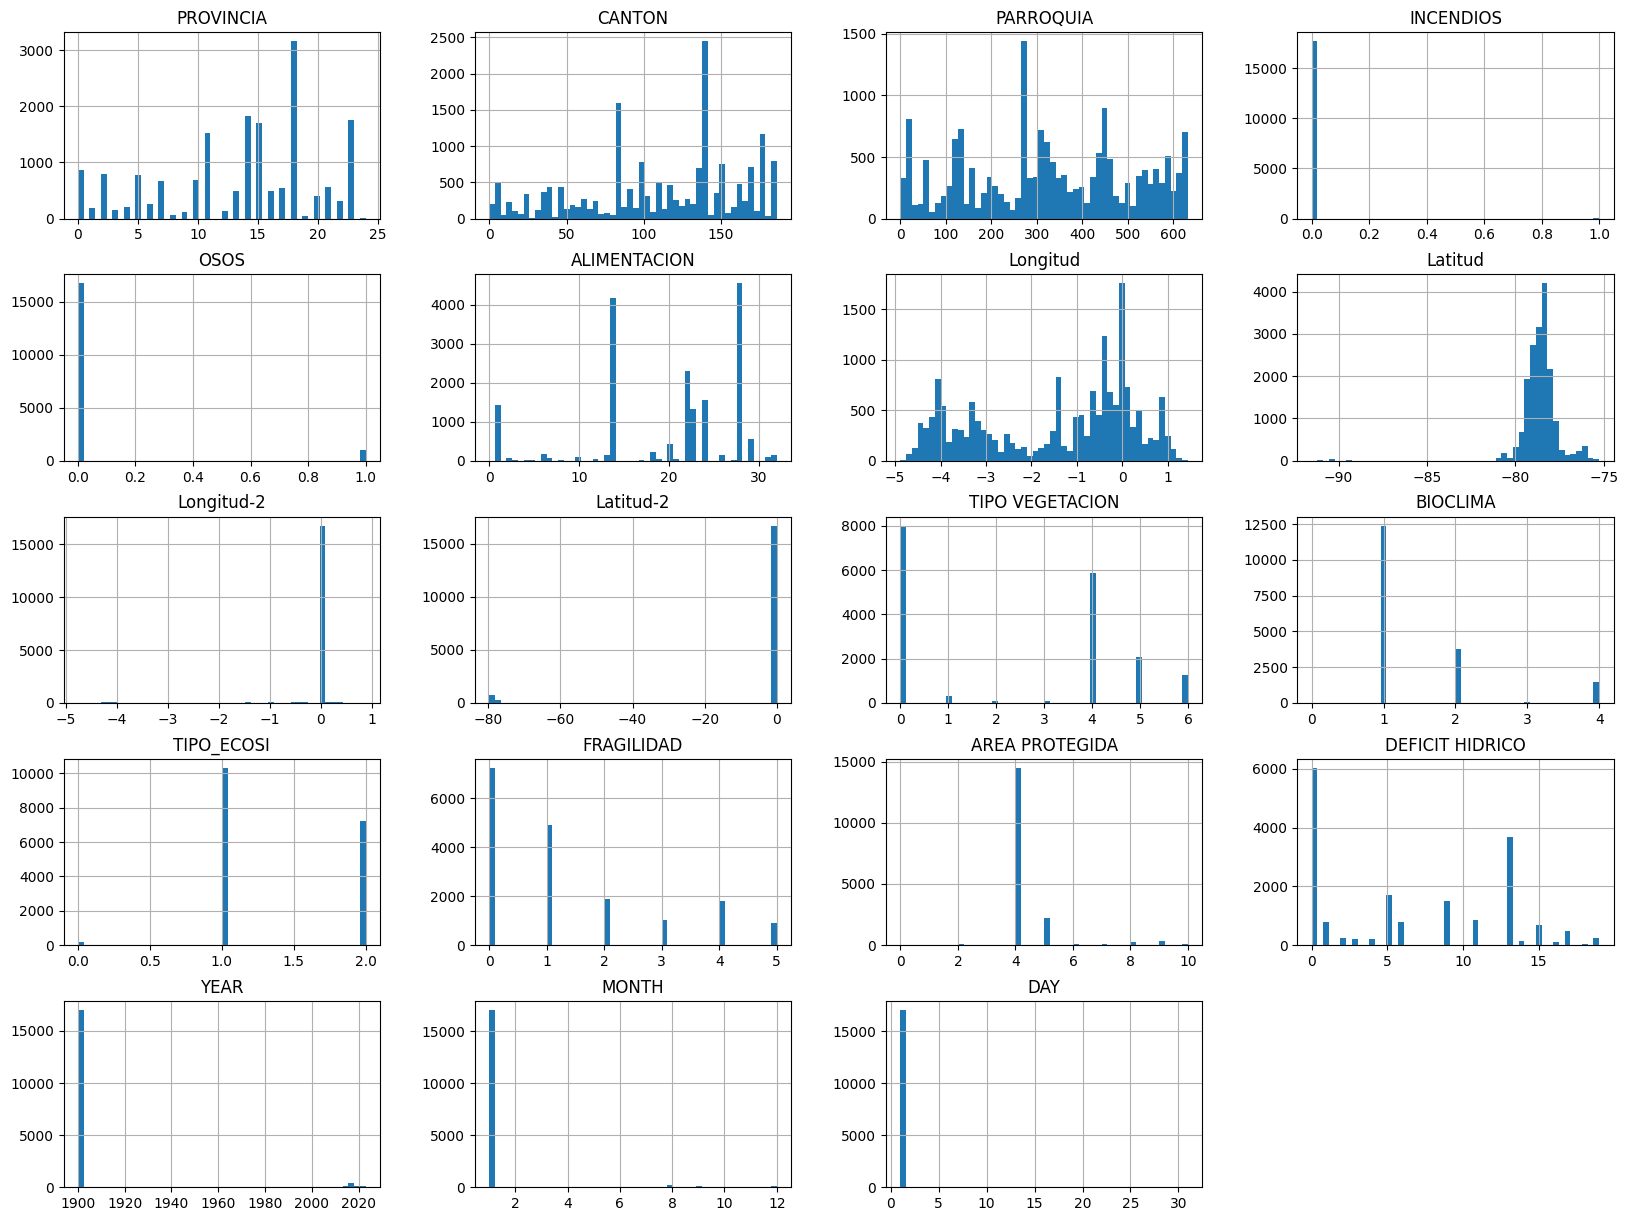

In [125]:
# Represento gráficamente los atributos
df_starup.hist(bins=50, figsize=(20,15))
plt.show()

In [126]:
# Copiamos el conjunto de datos para no alterar el original
df_starup = df1.copy()


In [127]:
## Filtrar datos por un atributo
#df1 = df1_copy
#df_starup = df1.loc[df1['OSOS'] == "SI"]

#df_starup.tail(10)

### Análisis de correlaciones

In [128]:

##columnas_categoricas = ['Provincia','Canton','Parroquia','Alimentacion','INCENDIOS','OSOS','TIPO VEGETACION','BIOCLIMA','tipo_ecosi','AREA PROTEGIDA','Deficit Hidrico','fragilidad']
columnas_categoricas = ['PROVINCIA','CANTON','PARROQUIA','ALIMENTACION','INCENDIOS','OSOS','TIPO VEGETACION','BIOCLIMA','TIPO_ECOSI','AREA PROTEGIDA','DEFICIT HIDRICO','FRAGILIDAD']
le = LabelEncoder()
df_starup[columnas_categoricas] = df_starup [columnas_categoricas].apply(lambda col: le.fit_transform(col.astype(str)))

In [129]:
df_starup.tail(10)

,PROVINCIA,CANTON,PARROQUIA,INCENDIOS,OSOS,ALIMENTACION,Longitud,Latitud,Longitud-2,Latitud-2,TIPO VEGETACION,BIOCLIMA,TIPO_ECOSI,FRAGILIDAD,AREA PROTEGIDA,DEFICIT HIDRICO,YEAR,MONTH,DAY
17729,18,139,479,0,0,14,0.16666,-78.58333,0.0,0.0,4,2,2,0,4,13,1900,1,1
17730,14,161,530,0,0,22,-2.70000,-78.30000,0.0,0.0,4,1,2,0,4,0,1900,1,1
17731,15,135,555,0,0,29,-0.53333,-77.78333,0.0,0.0,0,1,1,2,5,0,1900,1,1
17732,18,129,409,0,0,14,0.00000,-79.20000,0.0,0.0,4,1,2,0,4,13,1900,1,1
17733,12,17,364,0,0,28,-0.58333,-79.36666,0.0,0.0,4,2,1,1,4,0,1900,1,1
17734,12,17,364,0,0,22,-0.58333,-79.36666,0.0,0.0,4,2,1,1,4,0,1900,1,1
17735,12,17,364,0,0,14,-0.58333,-79.36666,0.0,0.0,4,2,1,1,4,0,1900,1,1
17736,12,17,364,0,0,7,-0.58333,-79.36666,0.0,0.0,4,2,1,1,4,0,1900,1,1
17737,12,17,364,0,0,1,-0.58333,-79.36666,0.0,0.0,4,2,1,1,4,0,1900,1,1
17738,0,38,611,0,0,28,-3.10000,-79.08333,0.0,0.0,4,2,2,0,4,11,1900,1,1


In [130]:
# Mostrar la correlación entre los atributos conjunto de datos
corr_matrix = df_starup.corr()
corr_matrix[CLASE].sort_values(ascending=False)

OSOS               1.000000
YEAR               0.840384
DAY                0.748171
MONTH              0.737025
PROVINCIA          0.112658
PARROQUIA          0.051891
FRAGILIDAD         0.026526
Latitud            0.021628
CANTON             0.020348
ALIMENTACION       0.018500
AREA PROTEGIDA     0.006726
Longitud           0.003626
INCENDIOS          0.001586
TIPO VEGETACION   -0.015152
BIOCLIMA          -0.075934
TIPO_ECOSI        -0.082489
DEFICIT HIDRICO   -0.112627
Longitud-2        -0.607565
Latitud-2         -0.999984
Name: OSOS, dtype: float64

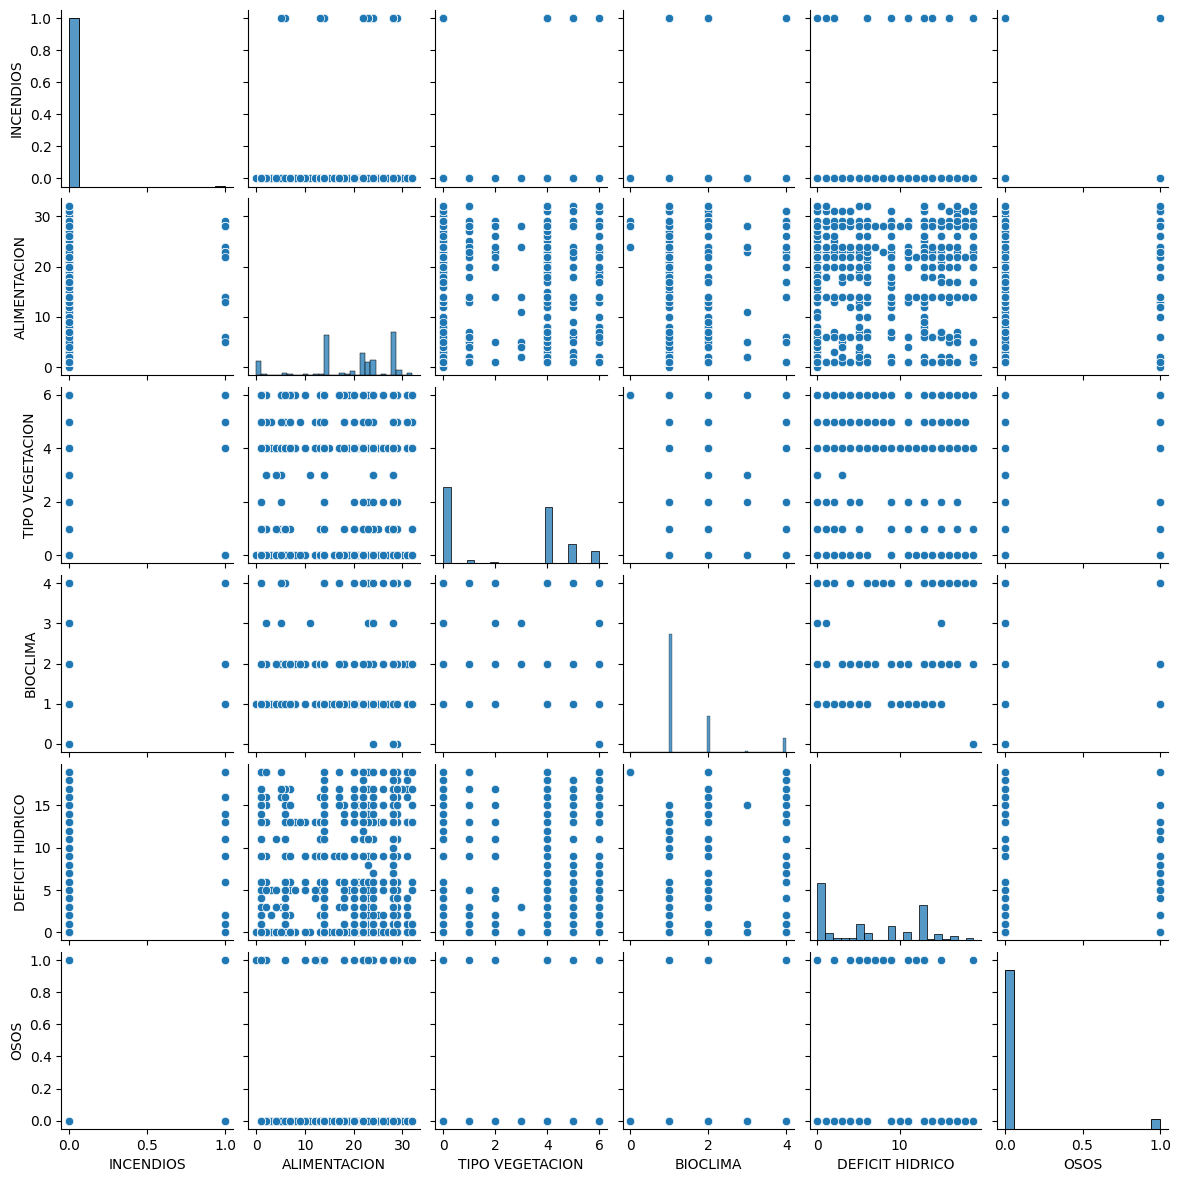

In [131]:
columnas = ["INCENDIOS","ALIMENTACION","TIPO VEGETACION","BIOCLIMA","DEFICIT HIDRICO","OSOS"]
sns.pairplot(df_starup[columnas], diag_kind="auto",height =2)


In [132]:
# Mostrar correlación lineal entre todos los atributos del conjunto de datos
df_starup.corr()

,PROVINCIA,CANTON,PARROQUIA,INCENDIOS,OSOS,ALIMENTACION,Longitud,Latitud,Longitud-2,Latitud-2,TIPO VEGETACION,BIOCLIMA,TIPO_ECOSI,FRAGILIDAD,AREA PROTEGIDA,DEFICIT HIDRICO,YEAR,MONTH,DAY
PROVINCIA,1.000000,0.099274,0.195162,-0.026953,0.112658,-0.135685,-0.095255,0.221388,-0.147157,-0.112961,-0.113492,-0.143320,-0.153786,0.155686,0.096610,-0.187634,0.107139,0.097904,0.107231
CANTON,0.099274,1.000000,0.077074,-0.019903,0.020348,0.071127,0.158017,-0.067732,-0.073844,-0.020727,-0.003609,-0.018150,0.052248,-0.037712,-0.012736,0.043404,0.017253,0.014686,0.015077
PARROQUIA,0.195162,0.077074,1.000000,-0.008307,0.051891,0.048955,-0.299277,-0.095956,-0.128652,-0.052432,0.054777,0.015557,-0.045001,0.013472,-0.137034,-0.033755,0.032444,0.032242,0.027658
INCENDIOS,-0.026953,-0.019903,-0.008307,1.000000,0.001586,0.023822,-0.001858,-0.012203,0.006214,-0.001528,0.038506,0.020426,0.030733,-0.025024,0.004085,0.041973,0.006487,0.007019,-0.001458
OSOS,0.112658,0.020348,0.051891,0.001586,1.000000,0.018500,0.003626,0.021628,-0.607565,-0.999984,-0.015152,-0.075934,-0.082489,0.026526,0.006726,-0.112627,0.840384,0.737025,0.748171
ALIMENTACION,-0.135685,0.071127,0.048955,0.023822,0.018500,1.000000,-0.071689,-0.222402,-0.008016,-0.018472,0.214357,0.234491,0.117505,-0.149616,-0.035533,0.239030,0.010962,-0.000249,-0.006893
Longitud,-0.095255,0.158017,-0.299277,-0.001858,0.003626,-0.071689,1.000000,0.219526,0.199218,-0.002508,0.055601,0.037867,0.115493,-0.121573,0.105284,0.138370,0.021309,0.008915,0.007332
Latitud,0.221388,-0.067732,-0.095956,-0.012203,0.021628,-0.222402,0.219526,1.000000,0.044612,-0.021105,-0.148910,-0.338281,-0.203534,0.234336,0.048160,-0.334645,0.026874,0.020014,0.023165
Longitud-2,-0.147157,-0.073844,-0.128652,0.006214,-0.607565,-0.008016,0.199218,0.044612,1.000000,0.611051,0.052776,0.072560,0.072992,-0.037627,-0.010434,0.065739,-0.452352,-0.427486,-0.439013
Latitud-2,-0.112961,-0.020727,-0.052432,-0.001528,-0.999984,-0.018472,-0.002508,-0.021105,0.611051,1.000000,0.015389,0.075911,0.082429,-0.026332,-0.006560,0.112316,-0.839871,-0.736787,-0.747767


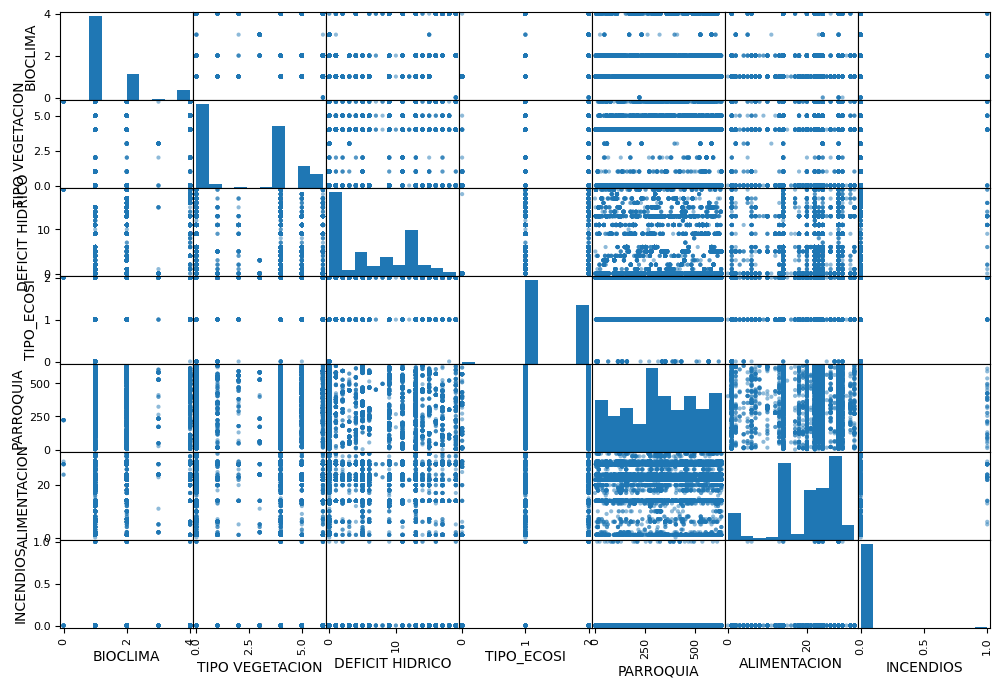

In [133]:
# Representar gráficamente las correlaciones

from pandas.plotting import scatter_matrix

attributes = ["BIOCLIMA", "TIPO VEGETACION", "DEFICIT HIDRICO", "TIPO_ECOSI","PARROQUIA","ALIMENTACION","INCENDIOS"]

scatter_matrix(df_starup[attributes], figsize=(12,8))
plt.show()

### Selección de atributos

In [134]:
# Seleccionamos aquellas variables que tienen mayor correlacion
columnas= ["BIOCLIMA", "TIPO VEGETACION","DEFICIT HIDRICO", "ALIMENTACION","PARROQUIA","OSOS","YEAR","MONTH","DAY","Latitud","Longitud"]
df = seleccionar_atributos(df1, columnas)
df_seleccionado = df.copy()
df.tail(3)


,BIOCLIMA,TIPO VEGETACION,DEFICIT HIDRICO,ALIMENTACION,PARROQUIA,OSOS,YEAR,MONTH,DAY,Latitud,Longitud
17736,PLUVIESTACIONAL,TIERRA AGROPECUARIA,000 - 000,Catopsis,PATRICIA PILAR,NO,1900,1,1,-79.36666,-0.58333
17737,PLUVIESTACIONAL,TIERRA AGROPECUARIA,000 - 000,Aechmea,PATRICIA PILAR,NO,1900,1,1,-79.36666,-0.58333
17738,PLUVIESTACIONAL,TIERRA AGROPECUARIA,450 - 475,Tillandsia,VICTORIA DEL PORTETE (IRQUIS),NO,1900,1,1,-79.08333,-3.10000


In [135]:
#correlation_matrix = df.corr()
#top_corr_features = correlation_matrix.index
#plt.figure(figsize=(20,20))
#plot heat map
#g=sns.heatmap(df[top_corr_features].corr(),annot=True,cmap="RdYlGn")

### División del conjunto de datos

In [136]:
#Definir tamaño de la muestra
test_porcentaje = 0.40
val_porcentaje = 0.50
var_stratify = CLASE
train_set, val_set, test_set = train_val_test_split(df, stratify=var_stratify)

In [137]:
print("Longitud del conjunto de datos:", len(df))
print("Longitud del conjunto de Entrenamiento Set:", len(train_set))
print("Longitud del conjunto de Validacion:", len(val_set))
print("Longitud del conjunto de pruebas:", len(test_set))

Longitud del conjunto de datos: 17739
Longitud del conjunto de Entrenamiento Set: 10643
Longitud del conjunto de Validacion: 3548
Longitud del conjunto de pruebas: 3548


<Axes: >

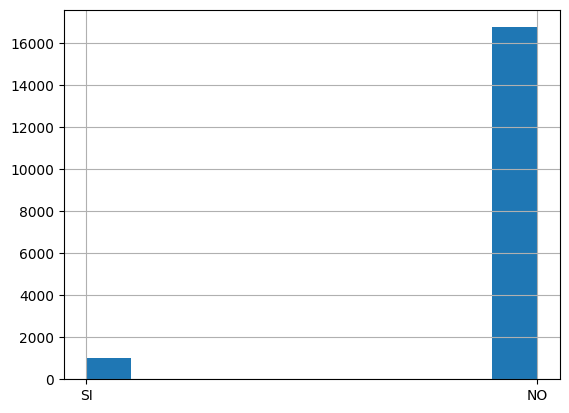

In [138]:
# Comprobación de que stratify mantiene la proporcion de la característica en los conjuntos
%matplotlib inline
import matplotlib.pyplot as plt
df[var_stratify].hist()

<Axes: >

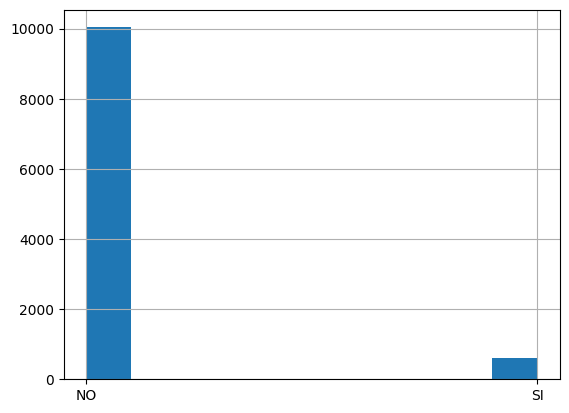

In [139]:
train_set[var_stratify].hist()

<Axes: >

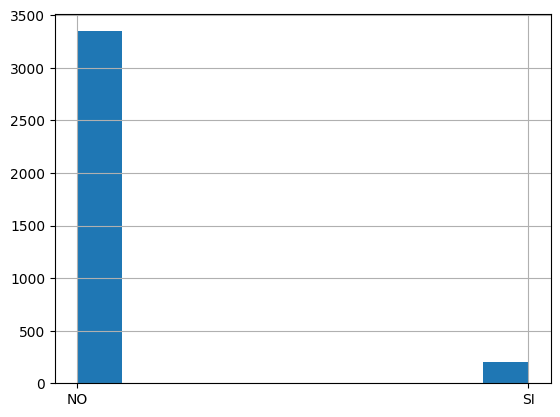

In [140]:
val_set[var_stratify].hist()

<Axes: >

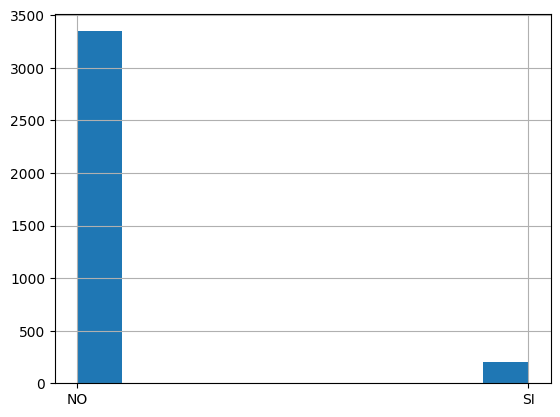

In [141]:
test_set[var_stratify].hist()

Como se observa los 3 conjuntos de datos de entrenamiento, validación y pruebas
mantienen la misma proporción


Para cada uno de los subconjuntos, separamos las etiquetas de las características de entrada.

In [142]:
# Conjunto de datos general
X_df, y_df = remove_labels(df, var_stratify)
# Conjunto de datos de entrenamiento
X_train, y_train = remove_labels(train_set, var_stratify)
# Conjunto de datos de validación
X_val, y_val = remove_labels(val_set, var_stratify)
# Conjunto de datos de pruebas
X_test, y_test = remove_labels(test_set, var_stratify)

### Preparación del conjunto de datos

In [143]:
# Instanciamos nuestro transformador personalizado
data_preparer = DataFramePreparer()

In [144]:
# Hacemos el fit con el conjunto de datos general para que adquiera todos los valores posibles
data_preparer.fit(X_df)
# Transformamos el subconjunto de datos de entrenamiento
X_train_prep = data_preparer.transform(X_train)
# Transformamos el subconjunto de datos de validacion
X_val_prep = data_preparer.transform(X_val)
# Transformamos el subconjunto de datos de validacion
X_test_prep = data_preparer.transform(X_test)


c:\Anaconda\envs\MiAmbiente\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [145]:
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_prep)

scaler = RobustScaler()
X_test_scaled = scaler.fit_transform(X_test_prep)

scaler = RobustScaler()
X_val_scaled = scaler.fit_transform(X_val_prep)

In [146]:
X_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17739 entries, 0 to 17738
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   BIOCLIMA         17739 non-null  object 
 1   TIPO VEGETACION  17739 non-null  object 
 2   DEFICIT HIDRICO  17739 non-null  object 
 3   ALIMENTACION     17739 non-null  object 
 4   PARROQUIA        17739 non-null  object 
 5   YEAR             17739 non-null  int64  
 6   MONTH            17739 non-null  int64  
 7   DAY              17739 non-null  int64  
 8   Latitud          17739 non-null  float64
 9   Longitud         17739 non-null  float64
dtypes: float64(2), int64(3), object(5)
memory usage: 1.4+ MB


In [147]:
# Hacemos el fit con el conjunto de datos general para que adquiera todos los valores posibles
#data_preparer.fit(X_df)

In [148]:
# Transformamos el subconjunto de datos de entrenamiento
# X_train_prep = data_preparer.transform(X_train)

In [149]:
X_train.head(5)

,BIOCLIMA,TIPO VEGETACION,DEFICIT HIDRICO,ALIMENTACION,PARROQUIA,YEAR,MONTH,DAY,Latitud,Longitud
13107,PLUVIAL,TIERRA AGROPECUARIA,000 - 000,Aechmea,AHUANO,1900,1,1,-77.58000,-1.03000
8815,PLUVIAL,BOSQUE,775 - 800,Guzmania,TULULBI (CAB. EN RICAURTE),1900,1,1,-78.60000,1.03333
586,PLUVIAL,BOSQUE,375 - 400,Gregbrownia,LOJA,1900,1,1,-79.16670,-4.00830
17579,PLUVIESTACIONAL,BOSQUE,140 - 150,Guzmania,LAS PAMPAS,1900,1,1,-79.00672,-0.42639
6032,PLUVIAL,TIERRA AGROPECUARIA,70 - 80,Tillandsia,MARIANO ACOSTA,1900,1,1,-77.95000,0.30000


In [150]:
## Visualización de los datos transformados
X_train_prep.head(5)

,YEAR,MONTH,DAY,Latitud,Longitud,BIOCLIMA_DESÉRTICO,BIOCLIMA_PLUVIAL,BIOCLIMA_PLUVIESTACIONAL,BIOCLIMA_SIN INFORMACION,BIOCLIMA_XÉRICO,...,PARROQUIA_ZAMORA,PARROQUIA_ZAPALLO,PARROQUIA_ZAPOTAL,PARROQUIA_ZARUMA,PARROQUIA_ZHAGLLI (SHAGLLI ),PARROQUIA_ZHUD,PARROQUIA_ZUMBA,PARROQUIA_ZUMBAHUA,PARROQUIA_ZURMI,PARROQUIA_ZUÑA (ZUÑAC)
13107,0.0,0.0,0.0,1.124369,-0.060394,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8815,0.0,0.0,0.0,-0.078631,0.581388,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
586,0.0,0.0,0.0,-0.747004,-0.986770,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17579,0.0,0.0,0.0,-0.558322,0.127354,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6032,0.0,0.0,0.0,0.687987,0.353292,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [151]:
# Transformamos el subconjunto de datos de validacion
X_val_prep = data_preparer.transform(X_val)

### Entrenamiento de un algoritmo de Regresión Logística

Para realizar la instanciación de un algoritmo se utiliza una libreria de sklearn

In [152]:
# Entrenamos un algoritmo basado en regresión logística
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter=100)
clf.fit(X_train_prep, y_train)

LogisticRegression()

### Predicción

Se procede a realizar la predicción con el conjunto de validación

In [153]:
y_pred = clf.predict(X_val_prep)

In [154]:
from sklearn.metrics import confusion_matrix


In [155]:
matrix_rl= confusion_matrix(y_val, y_pred)
print(matrix_rl)

[[3343    4]
 [  47  154]]


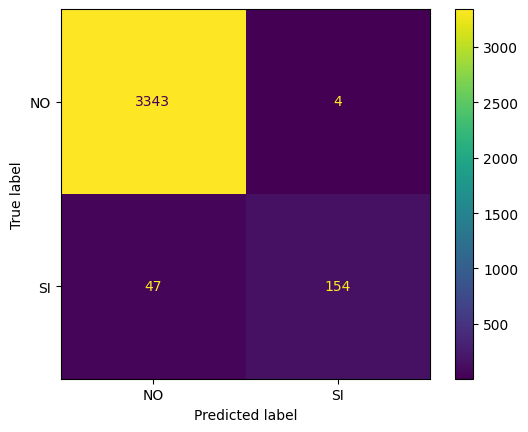

In [156]:
## Generar matriz de confusion
#X_test_prep, y_test
cm = confusion_matrix(y_val, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,     display_labels=clf.classes_)
disp.plot()
plt.show()



### Métricas derivadas de la matriz de confusión


In [157]:
## etiqueta evaluación
var_eva = VALOR_SEL

#### Precisión


In [158]:
from sklearn.metrics import precision_score

print("Precisión:", precision_score(y_val, y_pred, average = 'weighted' ))

Precisión: 0.9854869102584002


#### Recall

In [159]:
from sklearn.metrics import recall_score

print("Recall score:", recall_score(y_val, y_pred, average= 'weighted'))

Recall score: 0.9856257046223225


#### F1 Score

In [160]:
from sklearn.metrics import f1_score

print("F1 score:", f1_score(y_val, y_pred, average= 'weighted'))

F1 score: 0.9848107216334174


### Curvas ROC y PR

#### Curva Roc

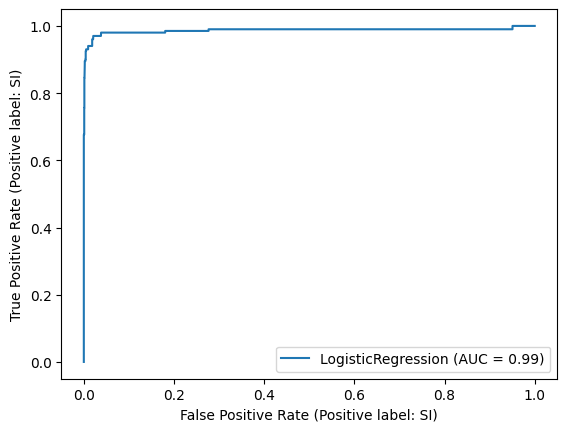

In [161]:
from sklearn.metrics import RocCurveDisplay

# Creamos la visualización
RocCurveDisplay.from_estimator(clf, X_val_prep, y_val)

# Mostramos la visualización
plt.show()


### Curva Pr

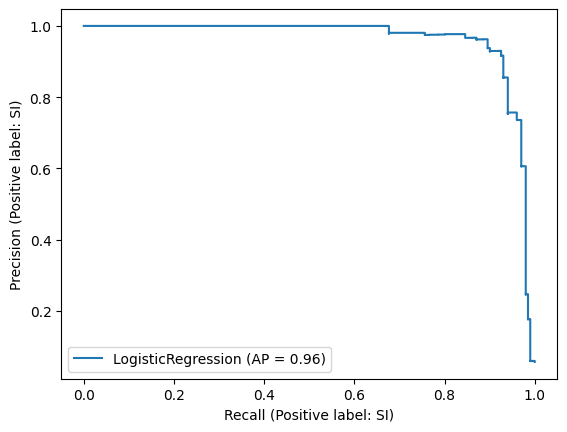

In [162]:
from sklearn.metrics import PrecisionRecallDisplay

PrecisionRecallDisplay.from_estimator( clf, X_val_prep, y_val)

plt.show()


### Evaluación del modelo datos de pruebas

In [163]:
# Transformamos el subconjunto de datos de validacion
# Tomando el conjunto test generamos el X_test

X_test_prep = data_preparer.transform(X_test)

In [164]:
y_pred = clf.predict(X_test_prep)

In [165]:
## Matriz de confusion

matrix_rl_test = confusion_matrix(y_test, y_pred)
print(matrix_rl_test)

[[3342    5]
 [  38  163]]


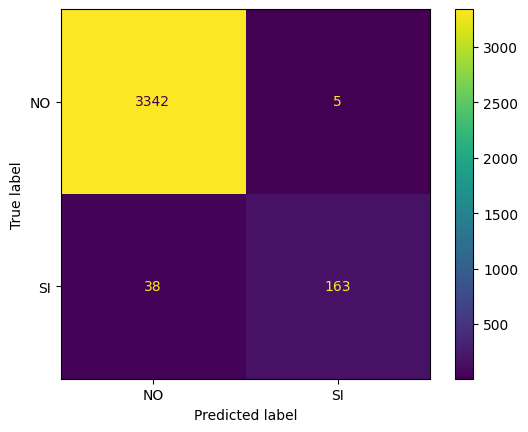

In [166]:
cm_test = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test,     display_labels=clf.classes_)
disp.plot()
plt.show()

In [167]:
print("Precisión:", precision_score(y_test, y_pred, average='weighted'))
print("F1 score:", f1_score(y_test, y_pred, average='weighted'))

Precisión: 0.9877082477621244
F1 score: 0.9873682937611061


### Entrenamiento Random Forest


### Escalar el conjunto de datos

Se realiza un escalado al conjunto de datos y se va a comparr con los resultados sin escalar

In [168]:
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_prep)

scaler = RobustScaler()
X_test_scaled = scaler.fit_transform(X_test_prep)

scaler = RobustScaler()
X_val_scaled = scaler.fit_transform(X_val_prep)

In [169]:
from pandas import DataFrame

X_train_scaled = DataFrame(X_train_scaled, columns = X_train_prep.columns, index=X_train_prep.index)
X_train_scaled.head(10)

,YEAR,MONTH,DAY,Latitud,Longitud,BIOCLIMA_DESÉRTICO,BIOCLIMA_PLUVIAL,BIOCLIMA_PLUVIESTACIONAL,BIOCLIMA_SIN INFORMACION,BIOCLIMA_XÉRICO,...,PARROQUIA_ZAMORA,PARROQUIA_ZAPALLO,PARROQUIA_ZAPOTAL,PARROQUIA_ZARUMA,PARROQUIA_ZHAGLLI (SHAGLLI ),PARROQUIA_ZHUD,PARROQUIA_ZUMBA,PARROQUIA_ZUMBAHUA,PARROQUIA_ZURMI,PARROQUIA_ZUÑA (ZUÑAC)
13107,0.0,0.0,0.0,1.122000,-0.061167,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8815,0.0,0.0,0.0,-0.078466,0.580554,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
586,0.0,0.0,0.0,-0.745431,-0.987455,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17579,0.0,0.0,0.0,-0.557146,0.126563,0.0,-1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6032,0.0,0.0,0.0,0.686537,0.352480,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16301,0.0,0.0,0.0,-1.679087,-0.754102,0.0,-1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15235,0.0,0.0,0.0,0.117693,-0.725694,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13396,0.0,0.0,0.0,1.902703,-0.129589,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7993,0.0,0.0,0.0,0.163793,-0.663321,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7228,0.0,0.0,0.0,-0.984347,-1.129058,0.0,-1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [170]:
X_train_scaled.describe()

,YEAR,MONTH,DAY,Latitud,Longitud,BIOCLIMA_DESÉRTICO,BIOCLIMA_PLUVIAL,BIOCLIMA_PLUVIESTACIONAL,BIOCLIMA_SIN INFORMACION,BIOCLIMA_XÉRICO,...,PARROQUIA_ZAMORA,PARROQUIA_ZAPALLO,PARROQUIA_ZAPOTAL,PARROQUIA_ZARUMA,PARROQUIA_ZHAGLLI (SHAGLLI ),PARROQUIA_ZHUD,PARROQUIA_ZUMBA,PARROQUIA_ZUMBAHUA,PARROQUIA_ZURMI,PARROQUIA_ZUÑA (ZUÑAC)
count,10643.000000,10643.000000,10643.000000,10643.000000,10643.000000,10643.000000,10643.000000,10643.000000,10643.000000,10643.000000,...,10643.000000,10643.000000,10643.000000,10643.000000,10643.000000,10643.00000,10643.000000,10643.000000,10643.000000,10643.000000
mean,4.871747,0.264869,0.737104,-0.057747,-0.188258,0.000564,-0.300855,0.214507,0.004604,0.081180,...,0.015221,0.000094,0.000470,0.000282,0.000094,0.00094,0.000282,0.000376,0.017664,0.001128
std,23.388373,1.440557,3.943198,1.301623,0.531819,0.023738,0.458651,0.410499,0.067699,0.273124,...,0.122438,0.009693,0.021671,0.016788,0.009693,0.03064,0.016788,0.019384,0.131734,0.033561
min,0.000000,0.000000,0.000000,-15.286958,-1.249234,0.000000,-1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,-0.588075,-0.742413,0.000000,-1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.411925,0.257587,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
max,123.000000,11.000000,30.000000,3.864241,0.708766,1.000000,0.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000


### Decision Forest

In [171]:
# Modelo entrenado con el conjunto de datos sin escalar
from sklearn.tree import DecisionTreeClassifier

clf_tree = DecisionTreeClassifier(random_state=42)
clf_tree.fit(X_train_prep, y_train)

DecisionTreeClassifier(random_state=42)

In [172]:
# Predecimos con el conjunto de datos de entrenamiento
y_train_pred = clf_tree.predict(X_train_prep)

In [173]:
print("F1 Score Conjunto Entrenamiento:", f1_score(y_train_pred, y_train, average='weighted'))

F1 Score Conjunto Entrenamiento: 0.9986785054708796


In [174]:
# Predecimos con el conjunto de datos de validación
y_val_pred = clf_tree.predict(X_val_prep)

In [175]:
from sklearn.metrics import confusion_matrix
matrix_df= confusion_matrix(y_val, y_pred)
print(matrix_df)

[[3188  159]
 [ 192    9]]


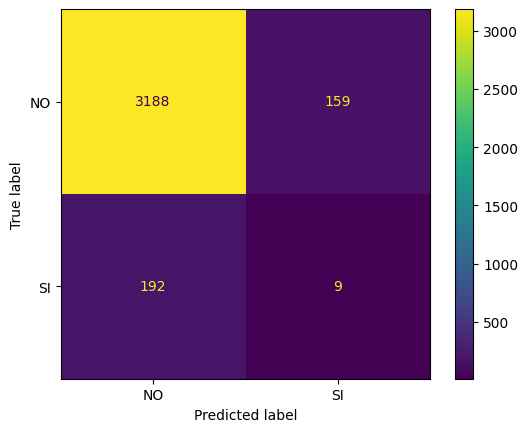

In [176]:
matriz_g(y_val, y_pred)

In [177]:
# Comparamos resultados entre escalado y sin escalar
#print("F1 Score Conjunto de Validación:", f1_score(y_val_pred, y_val, average='weighted'))
print("Precisión:", precision_score(y_test, y_pred, average='weighted'))
print("F1 score:", f1_score(y_test, y_pred, average='weighted'))

Precisión: 0.9877082477621244
F1 score: 0.9873682937611061


### Random Forest

In [178]:
from sklearn.ensemble import RandomForestClassifier

# Modelo entrenado con el conjunto de datos sin escalar
clf_rnd = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
clf_rnd.fit(X_train_prep, y_train)


RandomForestClassifier(n_jobs=-1, random_state=42)

In [179]:
# Modelo entrenado con el conjunto de datos escalado
clf_rnd_scaled = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
clf_rnd_scaled.fit(X_train_scaled, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [180]:
# Predecimos con el conjunto de datos de entrenamiento
y_train_pred = clf_tree.predict(X_train_prep)
y_train_prep_pred = clf_rnd_scaled.predict(X_train_scaled)

In [181]:
# Comparamos resultados entre escalado y sin escalar
evaluate_result(y_train_pred, y_train, y_train_prep_pred, y_train, f1_score)


f1_score WITHOUT preparation: 0.9986785054708796
f1_score WITH preparation: 0.9986785054708796


In [182]:
# Predecimos con el conjunto de datos de validación
y_pred = clf_rnd.predict(X_val_prep)
y_prep_pred = clf_rnd_scaled.predict(X_val_scaled)

c:\Anaconda\envs\MiAmbiente\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [183]:
from sklearn.metrics import confusion_matrix
matrix_rl= confusion_matrix(y_val, y_prep_pred)
print(matrix_rl)

[[3344    3]
 [   8  193]]


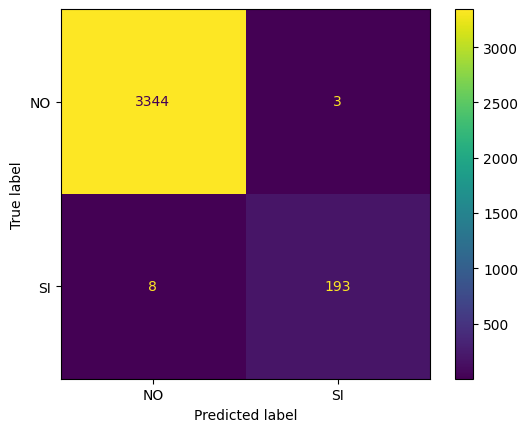

In [184]:
matriz_g(y_val, y_prep_pred)

In [185]:
# Comparamos resultados entre escalado y sin escalar
evaluate_result(y_pred, y_val, y_prep_pred, y_val, f1_score)

f1_score WITHOUT preparation: 0.9980293701807661
f1_score WITH preparation: 0.9969180283063976


### Arboles de Decision 

In [186]:
from sklearn.tree import DecisionTreeClassifier

MAX_DEPTH = 20

# Modelo entrenado con el conjunto de datos sin preparar
clf_tree = DecisionTreeClassifier(max_depth=MAX_DEPTH, random_state=42)
clf_tree.fit(X_train_prep, y_train)

# Modelo entrenado con el conjunto de datos escalado
clf_tree_scaled = DecisionTreeClassifier(max_depth=MAX_DEPTH, random_state=42)
clf_tree_scaled.fit(X_train_scaled, y_train)

DecisionTreeClassifier(max_depth=20, random_state=42)

In [187]:
# Predecimos con el conjunto de datos de entrenamiento
y_train_pred = clf_tree.predict(X_train_prep)
y_train_prep_pred = clf_tree_scaled.predict(X_train_scaled)

In [188]:
## Arbol de decision
# Comparamos resultados entre escalado y sin escalar
evaluate_result(y_train_pred, y_train, y_train_prep_pred, y_train, f1_score)

f1_score WITHOUT preparation: 0.9984920189100926
f1_score WITH preparation: 0.9984920189100926


In [189]:
X_train

,BIOCLIMA,TIPO VEGETACION,DEFICIT HIDRICO,ALIMENTACION,PARROQUIA,YEAR,MONTH,DAY,Latitud,Longitud
13107,PLUVIAL,TIERRA AGROPECUARIA,000 - 000,Aechmea,AHUANO,1900,1,1,-77.580000,-1.030000
8815,PLUVIAL,BOSQUE,775 - 800,Guzmania,TULULBI (CAB. EN RICAURTE),1900,1,1,-78.600000,1.033330
586,PLUVIAL,BOSQUE,375 - 400,Gregbrownia,LOJA,1900,1,1,-79.166700,-4.008300
17579,PLUVIESTACIONAL,BOSQUE,140 - 150,Guzmania,LAS PAMPAS,1900,1,1,-79.006720,-0.426390
6032,PLUVIAL,TIERRA AGROPECUARIA,70 - 80,Tillandsia,MARIANO ACOSTA,1900,1,1,-77.950000,0.300000
...,...,...,...,...,...,...,...,...,...,...
4986,PLUVIAL,ZONA ANTROPICA,25 - 50,Tillandsia,TUNDAYME,1900,1,1,-78.435000,-3.581667
1979,PLUVIAL,TIERRA AGROPECUARIA,000 - 000,Tillandsia,PAPALLACTA,1900,1,1,-78.151720,-0.357379
5226,PLUVIAL,TIERRA AGROPECUARIA,775 - 800,Pitcairnia,ALTO TAMBO (CAB EN GUADUAL),1900,1,1,-78.560000,0.959167
9203,PLUVIESTACIONAL,TIERRA AGROPECUARIA,375 - 400,Guzmania,EL TAMBO,1900,1,1,-79.233330,-4.050000


In [190]:
# Predecimos con el conjunto de datos de validación
y_pred = clf_tree.predict(X_val_prep)
y_prep_pred = clf_tree_scaled.predict(X_val_scaled)

c:\Anaconda\envs\MiAmbiente\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


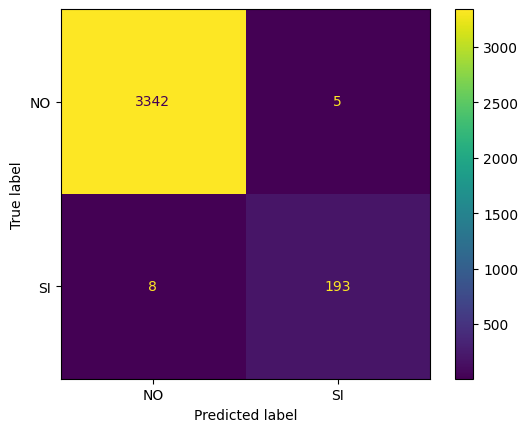

In [191]:
matriz_g(y_val, y_prep_pred)



```
# Tiene formato de código
```

### Clustering DBSCAN


In [192]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.gridspec as gridspec
from collections import Counter
from sklearn import metrics
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn import preprocessing


In [193]:
import sklearn.cluster

# Comprobar si st_dbscan está disponible
try:
    from sklearn.cluster import st_dbscan
except:
    print("El módulo st_dbscan no está disponible")

El módulo st_dbscan no está disponible


In [194]:
import sklearn

# Obtener una lista de las funciones de scikit-learn
functions = sklearn.__all__
# Imprimir la lista de funciones
print(functions)

['calibration', 'cluster', 'covariance', 'cross_decomposition', 'datasets', 'decomposition', 'dummy', 'ensemble', 'exceptions', 'experimental', 'externals', 'feature_extraction', 'feature_selection', 'gaussian_process', 'inspection', 'isotonic', 'kernel_approximation', 'kernel_ridge', 'linear_model', 'manifold', 'metrics', 'mixture', 'model_selection', 'multiclass', 'multioutput', 'naive_bayes', 'neighbors', 'neural_network', 'pipeline', 'preprocessing', 'random_projection', 'semi_supervised', 'svm', 'tree', 'discriminant_analysis', 'impute', 'compose', 'clone', 'get_config', 'set_config', 'config_context', 'show_versions']


In [195]:
# prompt: importar dbscan cluster
#!pip install scikit-learn-extra


### Funciones auxiliares


In [196]:
import numpy as np

from sklearn import metrics
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.3, min_samples=10).fit(X)
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

NameError: name 'X' is not defined

In [ ]:
import numpy as np
import pandas as pd
from sklearn.cluster import dbscan

# Cargar los datos
data = pd.DataFrame({
    "Latitud": [-12.0, -11.0, -10.0, -9.0, -8.0, -7.0, -6.0, -5.0],
    "Longitud": [-78.0, -77.0, -76.0, -75.0, -74.0, -73.0, -72.0, -71.0],
    "Especie": ["Puma", "Jaguar", "Puma", "Jaguar", "Puma", "Jaguar", "Puma", "Jaguar"]
})

# Aplicar st_dbscan
clf = DBSCAN(data, eps=0.3, min_samples=2)

# Imprimir las etiquetas de cluster
#print(clf.labels_)

TypeError: DBSCAN.__init__() got multiple values for argument 'eps'

In [ ]:
def var_categoricas(dataset):
     dataset.select_dtypes(include=['object'])
     dataset.columns
     input_labels = dataset.columns

     return input_labels


In [ ]:
def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

### Lectura de datos

In [ ]:
# fichero con cabecera
encoding = 'utf8'
url1 ='https://raw.githubusercontent.com/Taniapcc/TFM/main/base_ok.csv'
##url1 = "base_ok.csv"
sep = ";"
dfc1 = pd.read_csv(url1, sep=sep,encoding = encoding)

### Visualización

In [ ]:
dfc1.shape

In [ ]:
# 1006 Avistamientos de osos, 167333 No avistamientos
# El conjunto de datos se encuntra desequilabrado
dfc1["OSOS"].value_counts()

In [ ]:
# Visualizamos los tipos de cada uno de los atributos
dfc1.info()

In [ ]:
# Comprobamos si alguna columna tiene valores nulos
dfc1.isna().any()

In [ ]:
# Elimina las filas vacías
dfc1 = dfc1.dropna()


In [ ]:
dfc_starup.head()

In [ ]:
dfc1.shape

In [ ]:
le = LabelEncoder()
dfc_starup[columnas_categoricas] = df_starup [columnas_categoricas].apply(lambda col: le.fit_transform(col.astype(str)))

In [ ]:
# Copiamos el conjunto de datos para no alterar el original
dfc_starup = dfc1.copy()
##columnas_categoricas = ['Provincia','Canton','Parroquia','Alimentacion','INCENDIOS','OSOS','TIPO VEGETACION','BIOCLIMA','tipo_ecosi','AREA PROTEGIDA','Deficit Hidrico','fragilidad']
columnas_categoricas = ['PROVINCIA','CANTON','PARROQUIA','ALIMENTACION','INCENDIOS','TIPO VEGETACION','BIOCLIMA','TIPO_ECOSI','AREA PROTEGIDA','DEFICIT HIDRICO','FRAGILIDAD']


In [ ]:
#dfc_starup
dfc_filtrado = dfc_starup[dfc_starup['PROVINCIA'] == "PICHINCHA" & dfc_starup['Latitud_2'] != 0.0000]
#planets[planets.year.isin([2008, 2009]) & planets.mass.isnull()]

# Obtén los datos de los osos andinos

datos_latitud_longitud_oso = dfc_filtrado[['Latitud-2', 'Longitud-2']]
datos_latitud_longitud_oso

In [ ]:
def entrenar_modelo(datos_latitud_longitud_oso, datos_latitud_longitud_bromelia, epsilon, densidad_minima):

    # Preprocesar los datos

    datos_latitud_longitud_oso = preprocesar_datos(datos_latitud_longitud_oso)
    datos_latitud_longitud_bromelia = preprocesar_datos(datos_latitud_longitud_bromelia)

    # Entrenar el modelo

    modelo = DBSCAN(eps=epsilon, min_samples=densidad_minima)
    modelo.fit(datos_latitud_longitud_oso)

    return modelo


def preprocesar_datos(datos):

    # Eliminar datos incorrectos o incompletos

    datos = datos.dropna()

    # Estandarizar los datos de latitud y longitud

    datos_latitud = datos['latitud'].values
    datos_longitud = datos['longitud'].values

    datos_latitud = (datos_latitud - np.mean(datos_latitud)) / np.std(datos_latitud)
    datos_longitud = (datos_longitud - np.mean(datos_longitud)) / np.std(datos_longitud)

    datos = pd.DataFrame({'latitud': datos_latitud, 'longitud': datos_longitud})

    return datos


def identificar_relaciones(modelo, datos_latitud_longitud_bromelia):

    # Identificar grupos de datos

    grupos = modelo.fit_predict(datos_latitud_longitud_bromelia)

    # Devolver los grupos de datos

    return grupos

In [ ]:
# Importa las funciones
from funciones import entrenar_modelo, identificar_relaciones

# Importa el dataset
import pandas as pd
dataset = pd.read_csv('dataset.csv')

# Obtén los datos de los osos andinos
datos_latitud_longitud_oso = dataset[['latitud_oso', 'longitud_oso']]

# Obtén los datos de las bromelias
datos_latitud_longitud_bromelia = dataset[['latitud_bromelia', 'longitud_bromelia']]

# Obtén los valores de epsilon y densidad_minima
epsilon = 10.0
densidad_minima = 5

# Entrena el modelo
modelo = entrenar_modelo(datos_latitud_longitud_oso, datos_latitud_longitud_bromelia, epsilon, densidad_minima)

# Identifica las relaciones
grupos = identificar_relaciones(modelo, datos_latitud_longitud_bromelia)


ModuleNotFoundError: No module named 'funciones'

In [ ]:


features = dfc_starup.drop("OSOS", axis=1)


plt.figure(figsize=(12,32))
gs = gridspec.GridSpec(8, 4)
gs.update(hspace=0.8)

for i, f in enumerate(features):
    ax = plt.subplot(gs[i])
    sns.histplot(dfc1[f][df1["OSOS"] == 1])
    sns.histplot(dfc1[f][df1["OSOS"] == 0])
    ax.set_xlabel('')
    ax.set_title('feature: ' + str(f))

plt.show()

In [ ]:
import numpy as np
import pandas as pd

# Importar la biblioteca scikit-learn
try:
    from sklearn import st_dbscan
except:
    print("La biblioteca scikit-learn no está instalada")

In [ ]:
!pip install scikit-learn

In [ ]:
# Cargar los datos
data = pd.DataFrame({
    "Latitud": [-12.0, -11.0, -10.0, -9.0, -8.0, -7.0, -6.0, -5.0],
    "Longitud": [-78.0, -77.0, -76.0, -75.0, -74.0, -73.0, -72.0, -71.0],
    "Especie": ["Puma", "Jaguar", "Puma", "Jaguar", "Puma", "Jaguar", "Puma", "Jaguar"]
})

# Transformar las variables categóricas
data["Especie"] = data["Especie"].astype("category").cat.codes

# Aplicar DBSCAN
labels = dbscan(data, eps=0.5, min_pts=2)

# Calcular la densidad de puntos
densities = density(data, labels)

# Imprimir las densidades de puntos
print(densities)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.cluster import ST_DBSCAN

In [ ]:
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN

def generar_rutas_y_zonas_riesgo(puntos_geograficos):
    # Convertir los puntos geográficos a un DataFrame de Pandas
    puntos_geograficos = pd.DataFrame(puntos_geograficos, columns=["latitud", "longitud"])

    # Aplicar el algoritmo DBSCAN para agrupar los puntos geográficos
    dbscan = DBSCAN(eps=0.05, min_samples=10)
    clusters = dbscan.fit_predict(puntos_geograficos)

    # Obtener las rutas de los osos
    rutas = []
    for i in range(len(np.unique(clusters))):
        ruta = puntos_geograficos[clusters == i]
        rutas.append(ruta)

    # Identificar las zonas de riesgo
    zonas_riesgo = []
    for ruta in rutas:
        # Calcular la densidad de la ruta
        densidad = len(ruta) / ruta.shape[0]

        # Si la densidad es mayor o igual al umbral, la ruta es una zona de riesgo
        if densidad >= 5:
            zonas_riesgo.append(ruta)

    return rutas, zonas_riesgo


# Ejemplo de uso
puntos_geograficos = [(-0.123456, -78.901234), (-0.123456, -78.901235), (-0.123457, -78.901234),
                     (-0.123458, -78.901234), (-0.123459, -78.901234)]
rutas, zonas_riesgo = generar_rutas_y_zonas_riesgo(puntos_geograficos)

print(rutas)
print(zonas_riesgo)

In [ ]:
###
# Leer los datos
#data = pd.read_csv("datos_prediccion.csv")

# Predecir la distribución del oso
#probabilidades = modelo.predict_proba(data)

# Crear un mapa de la distribución potencial del oso
import matplotlib.pyplot as plt

#plt.scatter(data["longitud"], data["latitud"], c=probabilidades[:, 1])
#plt.xlabel("Longitud")
#plt.ylabel("Latitud")
#plt.title("Distribución potencial del oso")

#plt.show()

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

In [ ]:
### Clustering dbscan
pip install utm

In [ ]:
# Operaciones númericas
import numpy as np
import pandas as pd, json
from math import radians, cos, sin, asin, sqrt

# Manejo del tiempo
import datetime
import time

# Convertir de Grados decimales a UTM.
from pyproj import Proj
import utm

# Para la visualización
import matplotlib.pyplot as plt, time
%matplotlib inline
from matplotlib import style
from mpl_toolkits.mplot3d import axes3d
import seaborn as sns

# Visualización del mapa
import folium
from folium.plugins import HeatMap, HeatMapWithTime

# Algoritmo de Convex hull.
from scipy.spatial.distance import squareform
from scipy.spatial import ConvexHull


In [ ]:
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN

def generar_rutas_y_zonas_riesgo(puntos_geografidos):
    # Convertir los puntos geográficos a un DataFrame de Pandas
    puntos_geografidos = pd.DataFrame(puntos_geografidos, columns=["latitud", "longitud"])

    # Aplicar el algoritmo DBSCAN para agrupar los puntos geográficos
    dbscan = DBSCAN(eps=0.05, min_samples=10)
    clusters = dbscan.fit_predict(puntos_geografidos)

    # Obtener las rutas de los osos
    rutas = []
    for i in range(len(np.unique(clusters))):
        ruta = puntos_geografidos[clusters == i]
        rutas.append(ruta)

    # Identificar las zonas de riesgo
    zonas_riesgo = []
    for ruta in rutas:
        # Calcular la densidad de la ruta
        densidad = len(ruta) / ruta.shape[0]

        # Si la densidad es mayor o igual al umbral, la ruta es una zona de riesgo
        if densidad >= 5:
            zonas_riesgo.append(ruta)

    return rutas, zonas_riesgo


# Ejemplo de uso
puntos_geografidos = df[["Latitud", "Longitud"]]
rutas, zonas_riesgo = generar_rutas_y_zonas_riesgo(puntos_geografidos)

print(rutas)
print(zonas_riesgo)

NameError: name 'df' is not defined

## ¿Cuántos clusters? (Elbow Method)

In [ ]:
# Encontrar el número de clusters
from sklearn.cluster import KMeans
wcss = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(data)
    wcss.append(kmeans.inertia_)

import matplotlib.pyplot as plt
plt.plot(range(2, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

Con base en el gráfico inicialmente se tomó  el número de cluster = 5. Sin embargo, después del análisis se observó que no mejora el análisis de la data con relación a fijar el número de cluster en 3. Por lo cual, se continúa con número de cluster = 3, para el análisis respectivo.

##Definición de clusters k-means

In [ ]:
import warnings
xn_clusters = 3

warnings.filterwarnings('ignore')
kmeans = KMeans(n_clusters = xn_clusters, init = "k-means++", random_state = 42).fit(data)
data['cluster'] = kmeans.labels_
data.tail()


In [ ]:
data.head()

#Centros y Máximos valores de los clusters

In [ ]:
centers = pd.DataFrame(kmeans.cluster_centers_, columns=[columna1, columna2])
centers['freq'] = data['cluster'].value_counts()
centers['freq_r'] = data['cluster'].value_counts(normalize=True)
print(centers)

# Agrupar el DataFrame por la columna 'cluster' y obtener los valores máximos
cluster_max_values = data.groupby('cluster').max()
print(cluster_max_values)

## Visualización clusters con dos variables
Los centros en cyan

In [ ]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(10, 6))
ax = sns.scatterplot(x=columna1, y=columna2, hue='cluster', style='cluster',
                     ax=ax, data=data)
ax.set_xlim(0, 9.9e6)
#ax.set_ylim(0,)
centers.plot.scatter(x=columna1, y=columna2, ax=ax, s=50, color='cyan')
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(data[data['cluster']==0][columna1], data[data['cluster']==0][columna2], s = 30, c = 'blue', label = 'Cluster1')
plt.scatter(data[data['cluster']==1][columna1], data[data['cluster']==1][columna2], s = 30, c = 'violet', label = 'Cluster2')
plt.scatter(data[data['cluster']==2][columna1], data[data['cluster']==2][columna2], s = 30, c = 'yellow', label = 'Cluster3')
plt.scatter(data[data['cluster']==3][columna1], data[data['cluster']==3][columna2], s = 60, c = 'red', label = 'Cluster4')
#plt.scatter(data[data['cluster']==4][columna1], data[data['cluster']==4][columna2], s = 60, c = 'green', label = 'Cluster5')
#plt.scatter(data[data['cluster']==5][columna1], data[data['cluster']==5][columna2], s = 60, c = 'pink', label = 'Cluster6')
#plt.scatter(data[data['cluster']==6][columna1], data[data['cluster']==6][columna2], s = 60, c = 'brown', label = 'Cluster7')
#plt.scatter(data[data['cluster']==7][columna1], data[data['cluster']==7][columna2], s = 60, c = 'cyan', label = 'Cluster8')
#plt.scatter(centers[columna1], centers[columna2], s = 100, c = 'black', label = 'Centroids')
plt.xlabel(columna1)
plt.ylabel(columna2)
plt.legend()
plt.show()

Cluster 0: Este cluster tiene un valor de "cases" de 2,376,852 y un valor de "pulmonaryConfirmado" de 13,367. Esto indica que los puntos en este cluster tienen un alto número de casos y una baja confirmación pulmonar en comparación con los otros clusters.

Cluster 1: Este cluster tiene un valor de "cases" de 617,820 y un valor de "pulmonaryConfirmado" de 908,925. Esto sugiere que los puntos en este cluster tienen un número moderado de casos y una alta confirmación pulmonar.

Cluster 2: Este cluster tiene un valor de "cases" de 9,884,100 y un valor de "pulmonaryConfirmado" de 570,237. Esto indica que los puntos en este cluster tienen un alto número de casos y una moderada confirmación pulmonar en comparación con los otros clusters. Sin embargo, los datos en este caso son solo dos y muy dispersos. Por lo cual, este cluster no es caraterizable.


## Caracterización de los clusters

+ Cluster 0: CasosCovid Alto- Tuberculosis Baja (300/1).
+ Cluster 1: CasosCovid Medio - Tuberculosis Alta (3/1).
+ Cluster 2: no caracterizable, alta dispersión.

## Aplicación de K-Means con dos variables (2)
Se selecciona las variables 'deaths' y 'pulmonaryConfirmado'. Ahora se busca ver la relación entre muertes por posible COVID y la tuberculosis diagnosticada.

##Analisis intermedio
La tuberculosis está presente cuando hay fallecimiento por posible COVID.

In [ ]:
columna1 = 'OSOS'
columna2 = 'Alimentacion'
columna3 = 'BIOCLIMA'

columnas = ['Alimentacion','BIOCLIMA','TIPO VEGETACION']
#data0 = df_starup[[columna1,columna2]]
data0 = df_starup[columnas]
data0.reset_index(drop=True, inplace=True)

data0.head(200)

In [ ]:
from sklearn.cluster import KMeans
wcss = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(data0)
    wcss.append(kmeans.inertia_)

import matplotlib.pyplot as plt
plt.plot(range(2, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [ ]:
import warnings
xn_clusters = 4

warnings.filterwarnings('ignore')
kmeans = KMeans(n_clusters = xn_clusters, init = "k-means++", random_state = 42).fit(data0)
data0['cluster'] = kmeans.labels_
data0.tail()

In [ ]:
centers = pd.DataFrame(kmeans.cluster_centers_, columns=[columna1, columna2])
centers['freq'] = data0['cluster'].value_counts()
centers['freq_r'] = data0['cluster'].value_counts(normalize=True)
print(centers)

# Agrupar el DataFrame por la columna 'cluster' y obtener los valores máximos
cluster_max_values = data0.groupby('cluster').max()
print(cluster_max_values)

#Visualizacion

In [ ]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(10, 6))
ax = sns.scatterplot(x=columna1, y=columna2, hue='cluster', style='cluster',
                     ax=ax, data=data0)
#ax.set_xlim(0, 9.9e6)
#ax.set_ylim(0,)
centers.plot.scatter(x=columna1, y=columna2, ax=ax, s=50, color='cyan')
plt.tight_layout()
plt.show()

Se descarta la variable deaths, se descarta relación relevante entre muertes por posible COVID y tuberculosis diagnosticada.

# K-means con cuatro variables

Se analiza con mayor número de variables

In [ ]:
columna1 = 'year'
columna2 = 'OSOS'
columna3 = 'Alimentacion'
columna4 = ''
data1 = df_starup[[columna1,columna2, columna3, columna4]]
data1.reset_index(drop=True, inplace=True)
data1.head()

## Elbow Method

In [ ]:
from sklearn.cluster import KMeans
data_km=data1.copy()
wcss = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 12)
    kmeans.fit(data_km)
    wcss.append(kmeans.inertia_)

import matplotlib.pyplot as plt
plt.plot(range(2, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

## Definición de clusters

In [ ]:
import warnings
warnings.filterwarnings('ignore')
kmeans1 = KMeans(n_clusters = 5, init = "k-means++", random_state = 42).fit(data_km)
data_km['cluster'] = kmeans1.labels_

centers1 = pd.DataFrame(kmeans1.cluster_centers_, columns=[columna1,columna2, columna3, columna4])

centers1['freq']=data_km['cluster'].value_counts()
centers1['freq_r']=data_km['cluster'].value_counts(normalize=True)
centers1

## Clusters con data transformada (StandardScale)
## K-means

In [ ]:
from sklearn import preprocessing
data_sd = preprocessing.scale(data1)
data_sd = pd.DataFrame(data_sd, columns = [columna1,columna2, columna3, columna4])
data_sd.head()

## Elbow Method

In [ ]:
data_sd_km=data_sd.copy()
wcss = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 12)
    kmeans.fit(data_sd_km)
    wcss.append(kmeans.inertia_)


import matplotlib.pyplot as plt
plt.plot(range(2, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

## Definición de clusters data escalada

In [ ]:
import warnings
warnings.filterwarnings('ignore')
kmeans = KMeans(n_clusters = 7, init = "k-means++", random_state = 42).fit(data_sd)
data_sd_km['cluster'] = kmeans.labels_

centers2 = pd.DataFrame(kmeans.cluster_centers_, columns=[columna1,columna2, columna3, columna4])
centers2['freq']=data_sd_km['cluster'].value_counts()
centers2['freq_r']=data_sd_km['cluster'].value_counts(normalize=True)
print(centers2)

In [ ]:
data2=data1.copy()
data2['cluster']=data_sd_km['cluster']
Centers_mean=data2.groupby('cluster').mean()
Centers_mean

## Evaluación. Silhouette score

In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
data2['S_S'] = silhouette_samples(data_sd_km,data_sd_km['cluster'])
silhouette_score_mean = silhouette_score(data_sd_km,data_sd_km['cluster'])
print(silhouette_score_mean)

In [ ]:
Centers_mean=data2.groupby('cluster').mean()
Centers_mean['freq']=data2['cluster'].value_counts()
Centers_mean['freq_r']=data2['cluster'].value_counts(normalize=True)
Centers_mean

# Cluster Jerárquico toma data transformada (StandardScale, data_sd)
*El clustering jerárquico es un algoritmo de agrupamiento que crea una estructura de clusters anidados en forma de un árbol o dendrograma. Este tipo de algoritmo no requiere especificar el número de clusters de antemano y es útil para visualizar la estructura de los datos en diferentes niveles de detalle.
Hay dos enfoques principales para el clustering jerárquico: el enfoque aglomerativo y el enfoque divisivo.
La función scipy.cluster.hierarchy.linkage es una función de la biblioteca SciPy que se utiliza para calcular las distancias entre pares de puntos de datos en el contexto de clustering jerárquico aglomerativo. El método de enlace "ward" minimiza la varianza total dentro de los clusters al fusionarlos.*

In [ ]:
from matplotlib import pyplot as plt
import scipy.cluster.hierarchy as sch
data_sdh=data_sd.copy()
data_sdh1=data_sd.copy()
data1h=data1.copy()
dendrogram = sch.dendrogram(sch.linkage(data_sdh, method  = "ward"))
plt.title('Dendrogram')
plt.xlabel('')
plt.ylabel('distances')
plt.show()

## Definición de cluster AgglomerativeClustering y evaluación
El enfoque aglomerativo comienza con cada punto de datos como un cluster individual y fusiona iterativamente los clusters más similares hasta que todos los puntos de datos estén en un solo cluster.

In [ ]:
#https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html
from sklearn.cluster import AgglomerativeClustering
hc = AgglomerativeClustering(n_clusters = 7, affinity = 'euclidean', linkage ='ward')
y_hc=hc.fit_predict(data_sdh)
data1h['cluster_hc']=y_hc
data_sdh1['cluster_hc']=y_hc
data1h['S_S_hc'] = silhouette_samples(data_sdh1,data_sdh1['cluster_hc'])
silhouette_score_mean_hc = silhouette_score(data_sdh1,data_sdh1['cluster_hc'])
print(silhouette_score_mean_hc)

In [ ]:
Centers_mean_hc=data1h.groupby('cluster_hc').mean()
Centers_mean_hc['freq_hc']=data1h['cluster_hc'].value_counts()
Centers_mean_hc['freq_r_hc']=data1h['cluster_hc'].value_counts(normalize=True)
Centers_mean_hc

# DBSCAN toma data transformada (StandardScale, data_sd)
## Definición de clusters y evaluación
*DBSCAN (Density-Based Spatial Clustering of Applications with Noise) es un algoritmo de clustering basado en la densidad que es capaz de encontrar clusters de forma arbitraria en un conjunto de datos. A diferencia de otros algoritmos de clustering, como K-means, DBSCAN no requiere especificar el número de clusters de antemano y puede identificar puntos de datos como ruido o anomalías.*


In [ ]:
#https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html
#pip install hdbscan
from sklearn.cluster import DBSCAN
data_sd_db=data_sd.copy()
data1_db=data1.copy()
dbscan = DBSCAN(eps=0.75, min_samples=5).fit(data_sd_db)
#y_dbs = dbscan.fit_predict(data_sd_db)
y_dbs = dbscan.labels_
data_sd_db['cluster_dbs']=y_dbs
silhouette_score(data_sd_db, data_sd_db['cluster_dbs'])

In [ ]:
data1_db['cluster_dbs']=y_dbs
data1_db['S_S_dbs'] = silhouette_samples(data_sd_db,data_sd_db['cluster_dbs'])
silhouette_score_mean_hc = silhouette_score(data_sd_db,data_sd_db['cluster_dbs'])
Centers_mean_dbs=data1_db.groupby('cluster_dbs').mean()
Centers_mean_dbs['freq_dbs']=data1_db['cluster_dbs'].value_counts()
Centers_mean_dbs['freq_r_dbs']=data1_db['cluster_dbs'].value_counts(normalize=True)
Centers_mean_dbs
#Noisy samples are given the label -1.

Cluster -1: Este cluster se etiqueta como -1, lo que indica que contiene puntos de ruido.Este cluster indica que los datos pertenecen principalmente al año 2020. Además, tiene la mayor cantidad promedio de casos, confirmación pulmonar y S_S_dbs. Sin embargo, el valor promedio de freq_dbs es negativo, lo que puede indicar una dispersión o separación de los puntos de datos en este cluster. El valor promedio de freq_r_dbs es bajo, lo que indica una baja densidad relativa de los puntos en este cluster.

Cluster 0: Este cluster se caracteriza por tener un valor promedio de año en 2021. No tiene casos promedio, lo que indica que puede haber países sin reportes de casos Covid en ese año. Por otro lado, tiene un valor promedio relativamente alto en la variable de confirmación pulmonar. El valor promedio de S_S_dbs es significativo, lo que indica que este cluster tiene una densidad promedio más alta en comparación con otros clusters. Además, tanto el valor promedio de freq_dbs como el de freq_r_dbs son altos, lo que sugiere una alta densidad y proximidad de los puntos en este cluster.

Cluster 1: Este cluster se caracteriza por tener un valor promedio de año en 2020, igual que el cluster -1. Tiene una cantidad promedio moderada de casos COVID y confirmación pulmonar. El valor promedio de S_S_dbs es significativo pero ligeramente menor que en el Cluster 0. El valor promedio de freq_dbs y freq_r_dbs también es alto pero menor en comparación con el Cluster 0. Lo que sugiere que se trata de una cantidad moderada de paises donde hubo casos COVID y casos de pulmonía.

Cluster 2: Este cluster corresponde principalmente al año 2019. No tiene casos COVID promedio, lo que sugiere que puede representar países sin reportes de casos en ese año.Tiene un valor promedio relativamente alto en la variable de confirmación pulmonar. El valor promedio de S_S_dbs es alto, lo que indica que este cluster tiene una densidad promedio significativa. Los valores promedio de freq_dbs y freq_r_dbs también son altos, lo que sugiere una alta densidad y proximidad de los puntos en este cluster. Por lo dicho, este cluster corresponde a paises donde no llegó el COVID en 2019 y existieron altos reportes de tuberculosis.

También podemos concluir que 3 clusters signifiactivos han agrupados la data.Un número mayor de clusters podría no aportar más información.

#Ejemplo de filas del cluster 2.
##Mostrar los paises del cluster 2. En los cuales, para el año 2019, no hubieron casos covid pero sí tuberculosis.


In [ ]:
#La data pas'o por label encoder y preprocessing.scale()
#Mejor filtar de la data original
cluster_seleccionado = 2
columna_interes = 'country'
data_original = df_starup_original.copy()  #Copia del DataFrame original con nombre de paises
#print(data_original)

condicion1 = data_original['year'] == 2019
condicion2 = data_original['cases'] == 0
condicion3 = data_original['pulmonaryDiagnosed'] > 5870
filas_filtradas = data_original.loc[condicion1 & condicion2 & condicion3]
columnas_deseadas = ['year', 'country', 'cases', 'pulmonaryDiagnosed']
columnas_filtradas = filas_filtradas[columnas_deseadas]
print(columnas_filtradas)

## Clustering Fuzzy C-Means

In [ ]:
!pip install -U scikit-fuzzy

In [ ]:
import numpy as np
import pandas as pd
import skfuzzy as fuzz

# Obtener los datos para el clustering
data = df3[['cases', 'deaths', 'pulmonaryConfirmado']].values

# Definir los parámetros del algoritmo FCM
n_clusters = 5
m = 2  # Parámetro de exponente de pertenencia (usualmente se usa 2 para FCM)
error = 0.005  # Criterio de convergencia del algoritmo
maxiter = 150  # Número máximo de iteraciones

# Aplicar Fuzzy C-Means
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(data.T, n_clusters, m, error=error, maxiter=maxiter, init=None)

# Obtener los clusters asignados para cada punto de datos
clusters = np.argmax(u, axis=0)

# Agregar los clusters al DataFrame original
df3['cluster'] = clusters

# Mostrar los resultados
cluster_counts = df3.groupby(['cluster', 'country']).size().unstack(fill_value=0)
print(cluster_counts)

# Visualización de los resultados (requiere matplotlib)
import matplotlib.pyplot as plt

plt.scatter(df3['cases'], df3['deaths'], c=clusters, cmap='viridis')
plt.scatter(cntr[:, 0], cntr[:, 1], marker='x', c='r')
plt.xlabel('Casos')
plt.ylabel('Tuberculosis')
plt.title('Clustering solapado Fuzzy C-Means')
plt.show()


In [ ]:

#plt.scatter(df3['cases'], df3['deaths'], c=clusters, cmap='viridis')
plt.scatter(df3['deaths'], df3['pulmonaryConfirmado'], c=clusters, cmap='viridis')
plt.scatter(cntr[:, 0], cntr[:, 1], marker='x', c='r')
plt.xlabel('Muertes')
plt.ylabel('Tuberculosis')
plt.title('Clustering solapado Fuzzy C-Means')
plt.show()


# **Regresion Lineal**
Realizo la transformación a los datos RobustScaler
Esta transformación es robusta a los valores atípicos

In [ ]:
import numpy as np
import pandas as pd

# Data Visualización
import matplotlib.pyplot as plt
import seaborn as sns

data_lm = df_starup[df_starup['year'] == 2020][['pulmonaryConfirmado', 'deaths' ]]
data_lm.head()

In [ ]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
data_normalized = scaler.fit_transform(data_lm)
data_f = pd.DataFrame(data_normalized)
data_f = data_f.round(2)
print(data_f)

In [ ]:
data0 = data_f[[0,1]]
data0.reset_index(drop=True, inplace=True)
data0.head(200)
data0.rename(columns={0: 'pulmonary', 1: 'deaths'}, inplace=True)
data0.tail()

In [ ]:
import warnings
from sklearn.cluster import KMeans
xn_clusters = 5

warnings.filterwarnings('ignore')
kmeans = KMeans(n_clusters = xn_clusters, init = "k-means++", random_state = 42).fit(data0)
data0['cluster'] = kmeans.labels_
data0.tail()

In [ ]:
print(data0['cluster'].unique())

In [ ]:
plt.figure(figsize=(10,8))
sns.scatterplot(x="pulmonary",
                y="deaths",
                s=100,
                hue=kmeans.labels_,
                data=data0,
               palette="Set1")
plt.xlabel("Pulmonary")
plt.ylabel("Deaths")


In [ ]:
data_lm2 = data0.loc[data0['cluster'] == 4]
data_lm2.info()


In [ ]:
x = data_lm2['pulmonary']
y = data_lm2['deaths']

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.7, test_size = 0.3, random_state = 100)

In [ ]:
plt.scatter(x_train, y_train)
plt.plot(x_train, -7.19 + 0.526*x_train, 'r')
plt.show()

In [ ]:
import statsmodels.api as sm
# Add a constant to get an intercept
x_train_sm = sm.add_constant(x_train)

# Fit the resgression line using 'OLS'
lr = sm.OLS(y_train, x_train_sm).fit()

In [ ]:
lr.params

In [ ]:
print(lr.summary())

## REFERENCIAS

* df1 tomado de: https://data.europa.eu/euodp/es/data/dataset/covid-19-coronavirus-data
* df2 tomado de: https://apps.who.int/gho/data/view.main.57080WBIG?lang=en


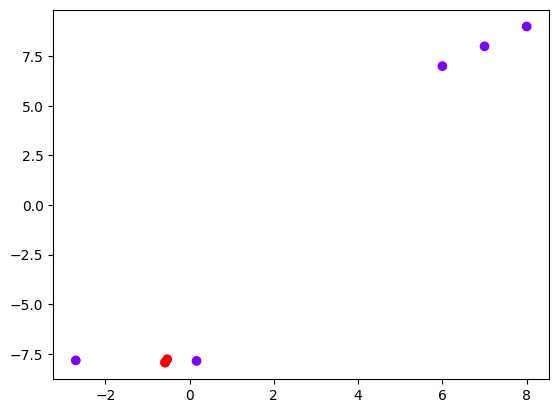

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

# Crear un conjunto de datos de puntos bidimensionales
X = np.array([[-0.58, -7.936], [-0.58, -7.936], [-0.53, -7.77], [0.166, -7.858], [-2.70, -7.830], [6, 7], [7, 8], [8, 9]])

# Aplicar DBSCAN al conjunto de datos
dbscan = DBSCAN(eps=0.5, min_samples=3)
labels = dbscan.fit_predict(X)

# Visualizar los clusters
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap="rainbow")
plt.show()